In [1]:
from ar6.utils.h5 import *
from ar6.utils.statistics import rmse
import numpy as np
import matplotlib.pyplot as pl
import json
import pandas as pd
import scipy.stats as st

NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

## Load observations

In [2]:
df = pd.read_csv('../data_input/AR6_OHC_ensemble_FGDprelim.csv', skiprows=1)
OHCobs = df['Central Estimate Full-depth'].values/0.9
OHC90 = df['Full-depth Uncertainty (1-sigma)'].values*NINETY_TO_ONESIGMA
#OHC90 = np.sqrt(OHC90[0]**2 + OHC90[-1]**2)

In [3]:
xl = pd.read_excel('../data_input/Consolidated GMST time series.xlsx', skiprows=8, skipfooter=9)
Tobs=xl['5-set mean'][:-1].values
years=xl['Unnamed: 0'][:-1].values

## Load runs

In [4]:
results = load_dict_from_hdf5('../data_input_large/twolayer_historical-AR6.h5')
SAMPLES=2000

/nfs/b0110/Users/mencsm/ar6/src/ar6/utils/h5.py:43: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


In [5]:
T = results['historical-AR6']['surface_temperature']
OHC = results['historical-AR6']['ocean_heat_content']

In [16]:
# simple criterion: RMSE of temperature 1850-2019 < 0.135
rmse_temp = np.zeros((SAMPLES))
for i in range(SAMPLES):
    rmse_temp[i] = rmse(Tobs, T[100:269,i]-np.mean(T[100:151,i], axis=0))
accept_temp=(rmse_temp<0.15)
print(np.sum(accept_temp))
valid_temp = np.arange(SAMPLES, dtype=int)[accept_temp]

451


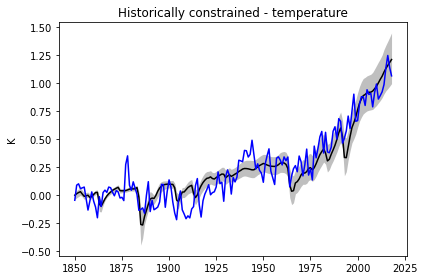

In [17]:
pl.fill_between(
    np.arange(1850, 2019),
    np.percentile(T[100:269,accept_temp]-np.mean(T[100:151,accept_temp], axis=0), 5, axis=1),
    np.percentile(T[100:269,accept_temp]-np.mean(T[100:151,accept_temp], axis=0), 95, axis=1), 
    color='gray', lw=0, alpha=0.5
)
pl.plot(
    np.arange(1850, 2019), 
    np.percentile(T[100:269,accept_temp]-np.mean(T[100:151,accept_temp], axis=0), 50, axis=1),
    color='k'
)
pl.plot(np.arange(1850, 2019), Tobs, color='blue')
pl.title('Historically constrained - temperature')
pl.ylabel('K')
pl.tight_layout()

In [8]:
accept_ohc = np.logical_and(
    ((OHCobs[-1]-OHCobs[0]) - np.sqrt(OHC90[0]**2+OHC90[-1]**2)) < (OHC[268,:]-OHC[221,:])*1e-21,
    (OHC[268,:]-OHC[221,:])*1e-21 < ((OHCobs[-1]-OHCobs[0]) + np.sqrt(OHC90[0]**2+OHC90[-1]**2))
)
valid_ohc = np.arange(SAMPLES, dtype=int)[accept_ohc]
print(np.sum(accept_ohc))

1109


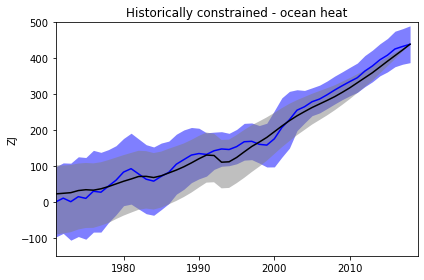

In [9]:
pl.fill_between(np.arange(1971,2019), OHCobs-OHC90, OHCobs+OHC90, color='blue', lw=0, alpha=0.5)
pl.plot(np.arange(1971,2019), OHCobs, color='blue')
pl.fill_between(np.arange(1750, 2019), OHCobs[-1]+1e-21*np.percentile((OHC[:269,accept_ohc]-OHC[268,accept_ohc]), 5, axis=1), OHCobs[-1]+1e-21*np.percentile((OHC[:269,accept_ohc]-OHC[268,accept_ohc]), 95, axis=1), color='gray', lw=0, alpha=0.5)
pl.plot(np.arange(1750, 2019), OHCobs[-1]+1e-21*np.percentile((OHC[:269,accept_ohc]-OHC[268,accept_ohc]), 50, axis=1), color='k')
pl.title('Historically constrained - ocean heat')
pl.xlim(1971,2019)
pl.ylim(-150,500)
pl.ylabel('ZJ')
pl.tight_layout()

In [10]:
accept_both = accept_temp * accept_ohc
accept_inds = (np.arange(len(accept_both), dtype=int))[accept_both]
len(accept_inds)

194

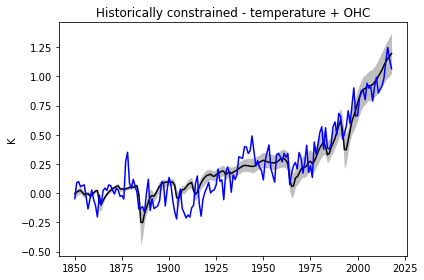

In [11]:
pl.fill_between(
    np.arange(1850, 2019),
    np.percentile(T[100:269,accept_both]-np.mean(T[100:151,accept_both], axis=0), 5, axis=1),
    np.percentile(T[100:269,accept_both]-np.mean(T[100:151,accept_both], axis=0), 95, axis=1), 
    color='gray', lw=0, alpha=0.5
)
pl.plot(
    np.arange(1850, 2019), 
    np.percentile(T[100:269,accept_both]-np.mean(T[100:151,accept_both], axis=0), 50, axis=1),
    color='k'
)
pl.plot(np.arange(1850, 2019), Tobs, color='blue')
pl.title('Historically constrained - temperature + OHC')
pl.ylabel('K')
pl.tight_layout()

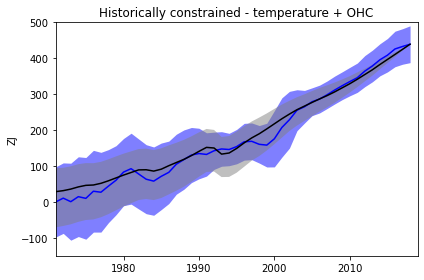

In [12]:
pl.fill_between(np.arange(1971,2019), OHCobs-OHC90, OHCobs+OHC90, color='blue', lw=0, alpha=0.5)
pl.plot(np.arange(1971,2019), OHCobs, color='blue')
pl.fill_between(np.arange(1750, 2019), OHCobs[-1]+1e-21*np.percentile((OHC[:269,accept_both]-OHC[268,accept_both]), 5, axis=1), OHCobs[-1]+1e-21*np.percentile((OHC[:269,accept_both]-OHC[268,accept_both]), 95, axis=1), color='gray', lw=0, alpha=0.5)
pl.plot(np.arange(1750, 2019), OHCobs[-1]+1e-21*np.percentile((OHC[:269,accept_both]-OHC[268,accept_both]), 50, axis=1), color='k')
pl.title('Historically constrained - temperature + OHC')
pl.xlim(1971,2019)
pl.ylim(-150,500)
pl.ylabel('ZJ')
pl.tight_layout()

array([1.92698911, 2.12281446, 2.67504654, 3.41490991, 4.4130435 ])

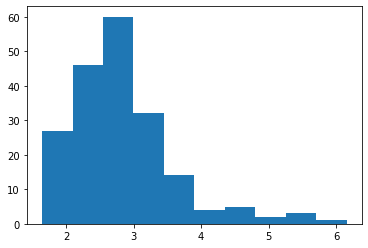

In [13]:
pl.hist(results['historical-AR6']['ECS'][accept_both]);
np.percentile(results['historical-AR6']['ECS'][accept_both], (5,16,50,84,95))

array([1.35148217, 1.50349033, 1.77609255, 2.08072183, 2.4365673 ])

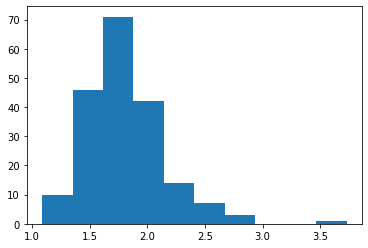

In [14]:
pl.hist(results['historical-AR6']['TCR'][accept_both]);
np.percentile(results['historical-AR6']['TCR'][accept_both], (5,16,50,84,95))

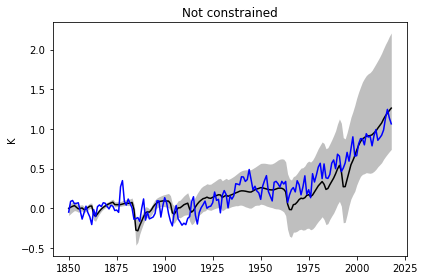

In [15]:
pl.fill_between(
    np.arange(1850, 2019),
    np.percentile(T[100:269,:]-np.mean(T[100:151,:], axis=0), 5, axis=1),
    np.percentile(T[100:269,:]-np.mean(T[100:151,:], axis=0), 95, axis=1), 
    color='gray', lw=0, alpha=0.5
)
pl.plot(
    np.arange(1850, 2019), 
    np.percentile(T[100:269,:]-np.mean(T[100:151,:], axis=0), 50, axis=1),
    color='k'
)
pl.plot(np.arange(1850, 2019), Tobs, color='blue')
pl.title('Not constrained')
pl.ylabel('K')
pl.tight_layout()